# GraPL Scratchpad

## Imports and Constants

In [2]:
%env CUDA_LAUNCH_BLOCKING=1
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
from GraPL import hyperparameter_profiles, segment_bsds, segment, GraPL_Segmentor, side_by_side, view_multichannel
import glob
import tqdm
import matplotlib.pyplot as plt
from GraPL.evaluate import bsds_score_directory, bsds_score
import numpy as np
import json
import os
import warnings
import torch
import pandas as pd
warnings.filterwarnings("ignore")

env: CUDA_LAUNCH_BLOCKING=1
env: CUBLAS_WORKSPACE_CONFIG=:4096:8
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testbench

Fitting...
CPU times: user 2.2 s, sys: 921 ms, total: 3.12 s
Wall time: 3.62 s
Predicting...
CPU times: user 2.16 ms, sys: 44.5 ms, total: 46.7 ms
Wall time: 70.4 ms


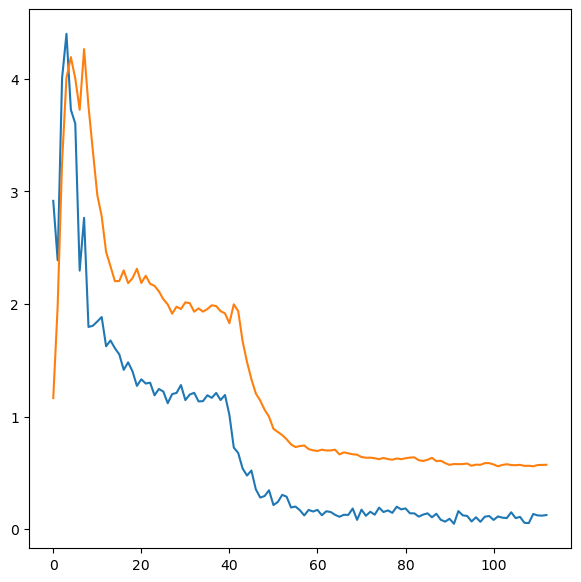

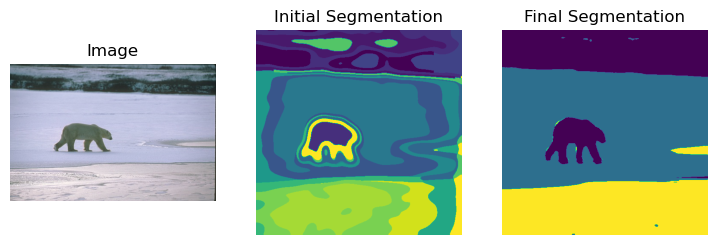

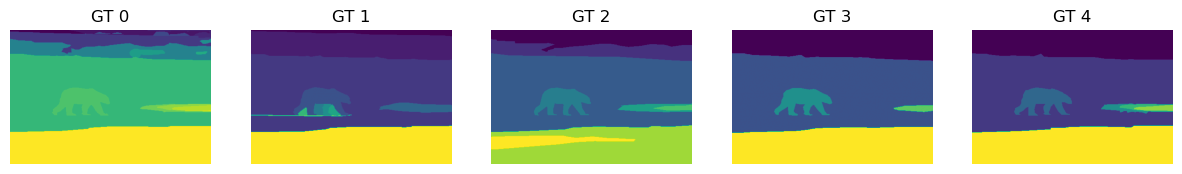

{'f1_score': 0.25299671894443365, 'accuracy': 0.3884482613454576, 'jaccard': 0.17096135113472283, 'v_measure': 0.5265880234218672, 'segmentation_covering': 0.26400903784499125, 'variation_of_information': 1.3453292219600115, 'probabalistic_rand_index': 0.7501897317505762, 'proportional_potts_energy': 0.02749047124047124, 'delta_k': nan, 'k_error': -0.9117177559282823, 'training_time': nan, 'prediction_time': nan, 'total_time': nan}


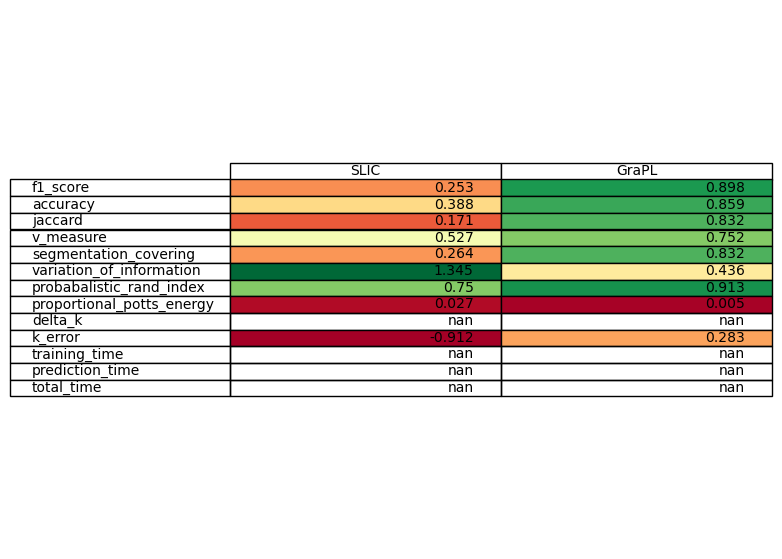

In [4]:
id = "100007"
image = plt.imread(f"datasets/BSDS500/BSDS500/data/images/test/{id}.jpg")

params = {
    'iterations': 4,
    'k': 14,
    'd': 32,
    'lambda_': 64,
    'subset_size': 0.5,
    'max_epochs': 40,
    'min_epochs': 12,
    'n_filters': 32,
    'bottleneck_dim': 8,
    'compactness': 0.1,
    'sigma': 10,
    'seed': 0,
    'use_continuity_loss': True,
    'continuity_range': 1,
    'continuity_p': 1,
    'continuity_weight': 2,
    'use_min_loss': True,
    'use_coords': False,
    'use_embeddings': False,
    'use_color_distance_weights': True,
    'initialization_method': 'slic',
    'use_fully_connected': True,
    'use_collapse_penalty': False,
    'use_cold_start': False,
    'num_layers': 3
}

segmentor = GraPL_Segmentor(**params)

print("Fitting...")
%time segmentor.fit(image)

print("Predicting...")
%time seg = segmentor.predict()

torch.cuda.empty_cache()

plt.plot(segmentor.intermediate_cross_entropies)
plt.plot(segmentor.intermediate_continuities)
plt.rcParams['figure.figsize'] = [7,7]
plt.show()

side_by_side([image, segmentor.initial_segmentation, seg], titles=["Image", "Initial Segmentation", "Final Segmentation"])

if segmentor.embeddings is not None:
    e = segmentor.embeddings.reshape(segmentor.d, segmentor.d, -1)
    view_multichannel(e / e.max())

gt_paths = glob.glob(f"datasets/BSDS500/gt/{id}-*.csv")
gts = []
for path in gt_paths:
    gts.append(np.loadtxt(path, delimiter=','))
side_by_side(gts, titles=[f"GT {i}" for i in range(len(gts))])

slic_scores = bsds_score(id, segmentor.initial_segmentation)
print(slic_scores)
slic_scores = {key: np.mean(slic_scores[key]) for key in slic_scores}
grapl_scores = bsds_score(id, seg)
grapl_scores = {key: np.mean(grapl_scores[key]) for key in grapl_scores}

df = pd.DataFrame([slic_scores, grapl_scores], index=["SLIC", "GraPL"])
df = df.transpose()
df = df.round(3)
plt.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellColours=plt.cm.RdYlGn(df.values))
plt.axis('off')
plt.show()